In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import tensorflow as tf

In [14]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "cats_vs_dogs"
ds, ds_info = tfds.load(
    dataset_name, split=["train"], with_info=True, as_supervised=True
)

ds_train = tfds.load(
    dataset_name, split=["train[:80%]"], as_supervised=True
)[0]

ds_test = tfds.load(
    dataset_name, split=["train[80%:]"], as_supervised=True
)[0]


NUM_CLASSES = ds_info.features["label"].num_classes
print(ds_info.features['label'].num_classes)
print(type(ds_train))

2
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [15]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

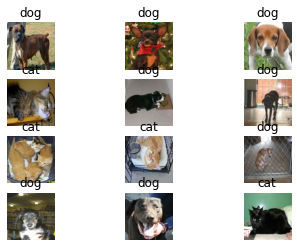

In [16]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(12)):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


In [17]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

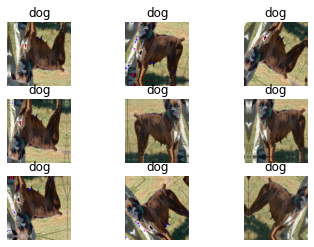

In [18]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


In [19]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [20]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [23]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Epoch 1/30
  2/290 [..............................] - ETA: 14s - loss: 0.8213 - accuracy: 0.6406WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0309s vs `on_train_batch_end` time: 0.0712s). Check your callbacks.


290/290 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.9168
Epoch 00001: val_loss improved from inf to 0.09912, saving model to cats_dogs_best_colab1.h5
290/290 [==============================] - 40s 138ms/step - loss: 0.3916 - accuracy: 0.9168 - val_loss: 0.0991 - val_accuracy: 0.9763
Epoch 2/30
290/290 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.9273
Epoch 00002: val_loss improved from 0.09912 to 0.09025, saving model to cats_dogs_best_colab1.h5
290/290 [==============================] - 39s 134ms/step - loss: 0.3379 - accuracy: 0.9273 - val_loss: 0.0902 - val_accuracy: 0.9757
Epoch 3/30
290/290 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.9279
Epoch 00003: val_loss improved from 0.09025 to 0.07045, saving model to cats_dogs_best_colab1.h5
290/290 [==============================] - 38s 132ms/step - loss: 0.2799 - accuracy: 0.9279 - val_loss: 0.0705 - val_accuracy: 0.9811
Epoch 4/30
290/290 [==============

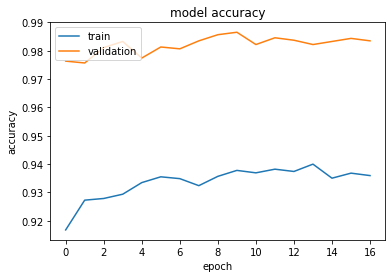

In [24]:
epochs = 30
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "cats_dogs_best_colab1.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1),
]
model = build_model(num_classes=NUM_CLASSES)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=callbacks)
plot_hist(hist)

In [ ]:
# load saved model
model.save('cats_dogs_efficientnet_colab.h5')